In [1]:
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk import word_tokenize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
import pickle
from nltk.stem import  PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

In [3]:
df=pd.read_csv('hm_train.csv')
df.isnull().sum()

hmid                  0
reflection_period     0
cleaned_hm            0
num_sentence          0
predicted_category    0
dtype: int64

In [4]:
df.head()

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category
0,27673,24h,I went on a successful date with someone I fel...,1,affection
1,27674,24h,I was happy when my son got 90% marks in his e...,1,affection
2,27675,24h,I went to the gym this morning and did yoga.,1,exercise
3,27676,24h,We had a serious talk with some friends of our...,2,bonding
4,27677,24h,I went with grandchildren to butterfly display...,1,affection


In [5]:
df.shape

(60321, 5)

In [6]:
df.predicted_category.unique()

array(['affection', 'exercise', 'bonding', 'leisure', 'achievement',
       'enjoy_the_moment', 'nature'], dtype=object)

In [7]:
df.predicted_category.value_counts()

affection           20880
achievement         20274
bonding              6561
enjoy_the_moment     6508
leisure              4242
nature               1127
exercise              729
Name: predicted_category, dtype: int64

In [8]:
df.num_sentence.unique()

array([ 1,  2,  3,  9,  6,  4, 53,  5, 12, 16,  7, 13, 11, 28,  8, 10, 14,
       17, 25, 27, 37, 34, 21, 23, 19, 26, 24, 22, 31, 18, 58, 32, 15, 29,
       35, 56, 51, 20, 46, 42, 30], dtype=int64)

In [9]:
df.reflection_period.value_counts()

24h    30455
3m     29866
Name: reflection_period, dtype: int64

In [10]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

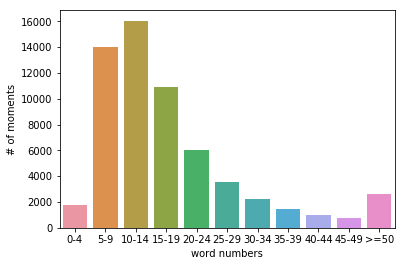

In [11]:
df_hm = df[df['cleaned_hm'].notnull()]
len_count = df_hm['cleaned_hm'].apply(lambda x: len(x.split()))
len_count.describe()
length_order = ["0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", \
                "40-44", "45-49", ">=50"]
length_category = len_count.apply(lambda x: length_order[min(10, int(x/5))])
length_counts = pd.DataFrame(length_category.value_counts()).reset_index()
length_counts.columns = ['word numbers', '# of moments']

sns.barplot(x='word numbers', y='# of moments', data=length_counts, order=length_order)

In [12]:
df.head()

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category
0,27673,24h,I went on a successful date with someone I fel...,1,affection
1,27674,24h,I was happy when my son got 90% marks in his e...,1,affection
2,27675,24h,I went to the gym this morning and did yoga.,1,exercise
3,27676,24h,We had a serious talk with some friends of our...,2,bonding
4,27677,24h,I went with grandchildren to butterfly display...,1,affection


In [13]:

def plt_count_freq(counts,title=None,_ylim=100000):
    freq = list(set(counts.values()))
    freq.sort()
    freq.reverse()
    plt.plot(freq)
    plt.xlabel('Terms')
    plt.ylabel('freq count')
    plt.ylim(0,_ylim)
    if(title!=None):
        plt.title(title)
    plt.show()

In [14]:

# function to clean data

stops = set(stopwords.words("english"))
def cleanData(text, lowercase = False, remove_stops = False, stemming = False):
    txt = str(text)
    txt = re.sub(r'[^A-Za-z0-9\s]',r'',txt)
    txt = re.sub(r'\n',r' ',txt)
    
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
        
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stops])
    
    if stemming:
        st = PorterStemmer()
        txt = " ".join([st.stem(w) for w in txt.split()])

    return txt

In [150]:
train=pd.read_csv('hm_train.csv')
#test=pd.read_csv('hm_test.csv')

In [151]:
#alldata = pd.concat([train, test]).reset_index(drop=True)

In [152]:
train.shape

(60321, 5)

In [153]:
train['predicted_category'] = train['predicted_category'].map({'affection': 0, 'exercise': 1, 'bonding': 2, 'leisure': 3, 'achievement': 4, 
                                                              'enjoy_the_moment': 5,'nature': 6})

In [154]:
train.head()

,hmid,reflection_period,cleaned_hm,num_sentence,predicted_category
0,27673,24h,I went on a successful date with someone I fel...,1,0
1,27674,24h,I was happy when my son got 90% marks in his e...,1,0
2,27675,24h,I went to the gym this morning and did yoga.,1,1
3,27676,24h,We had a serious talk with some friends of our...,2,2
4,27677,24h,I went with grandchildren to butterfly display...,1,0


In [155]:
import re
train['cleaned_hm'] = train['cleaned_hm'].map(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=True))

In [156]:

# initialise the functions - we'll create separate models for each type.
countvec = CountVectorizer(analyzer='word', ngram_range = (1,1), min_df=150, max_features=400)
tfidfvec = TfidfVectorizer(analyzer='word', ngram_range = (1,1), min_df = 150, max_features=400)

In [157]:

# create features
bagofwords = countvec.fit_transform(train['cleaned_hm'])
tfidfdata = tfidfvec.fit_transform(train['cleaned_hm'])

In [158]:

# create dataframe for features
bow_df = pd.DataFrame(bagofwords.todense())
tfidf_df = pd.DataFrame(tfidfdata.todense())

In [159]:
# set column names
bow_df.columns = ['col'+ str(x) for x in bow_df.columns]
tfidf_df.columns = ['col' + str(x) for x in tfidf_df.columns]

In [160]:

# create separate data frame for bag of words and tf-idf

bow_df_train = bow_df[:len(train)]
bow_df_test = bow_df[len(train):]

tfid_df_train = tfidf_df[:len(train)]
tfid_df_test = tfidf_df[len(train):]

In [161]:
train_1 = pd.concat([train, bow_df_train], axis = 1)
train_2 = pd.concat([train, tfid_df_train], axis=1)

In [162]:

# split the merged data file into train and test respectively
X = train_1.drop('predicted_category',1)
Y = train_1.predicted_category
x_train,x_test,y_train,y_test = train_test_split(X_1,Y,test_size=0.30,random_state=0)

In [163]:
X_1=X.drop(['hmid','reflection_period','cleaned_hm'],1)

In [164]:
X_1.head()

,num_sentence,col0,col1,col2,col3,col4,col5,col6,col7,col8,...,col390,col391,col392,col393,col394,col395,col396,col397,col398,col399
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

LGBM = LGBMClassifier(objective='multiclass',num_class='7',n_estimators=2000,learning_rate=0.05)

LGBM.fit(x_train, y_train)

y_pred_LGBM_train = LGBM.predict(x_test)

print(accuracy_score(y_test,y_pred_LGBM_train))

0.8334530585179865


In [166]:
X_2 = train_2.drop('predicted_category',1)
X_2=X.drop(['hmid','reflection_period','cleaned_hm'],1)
Y_2 = train_2.predicted_category
X_train,X_test,Y_train,Y_test = train_test_split(X_2,Y_2,test_size=0.30,random_state=0)
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

LGBM = LGBMClassifier(objective='multiclass',num_class='7',n_estimators=2000,learning_rate=0.05)

LGBM.fit(X_train, Y_train)

y_pred_LGBM_train = LGBM.predict(X_test)


print(accuracy_score(Y_test,y_pred_LGBM_train))

0.8339503785157761


# test_data_set

In [167]:
test=pd.read_csv('hm_test.csv')
test.head()

,hmid,reflection_period,cleaned_hm,num_sentence
0,88305,3m,I spent the weekend in Chicago with my friends.,1
1,88306,3m,We moved back into our house after a remodel. ...,2
2,88307,3m,My fiance proposed to me in front of my family...,1
3,88308,3m,I ate lobster at a fancy restaurant with some ...,1
4,88309,3m,I went out to a nice restaurant on a date with...,5


In [196]:
import re
test['cleaned_hm'] = test['cleaned_hm'].map(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=True))
test['cleaned_hm'].head()

0                         spent weekend chicago friend
1    move back hou remodel live hotel 9 month due h...
2                 fianc propo front famili begin march
3                     ate lobster fanci restaur friend
4    went nice restaur date wife popular restaur co...
Name: cleaned_hm, dtype: object

In [197]:
# initialise the functions - we'll create separate models for each type.
countvec = CountVectorizer(analyzer='word', ngram_range = (1,1), min_df=150, max_features=400)
tfidfvec = TfidfVectorizer(analyzer='word', ngram_range = (1,1), min_df=150, max_features=400)

In [198]:
# create features
bagofwords_test = countvec.fit_transform(test['cleaned_hm'])
tfidfdata_test = tfidfvec.fit_transform(test['cleaned_hm'])
bagofwords_test.shape

(40213, 400)

In [199]:
# create dataframe for features
bow_test_df = pd.DataFrame(bagofwords_test.todense())
tfidf_test_df = pd.DataFrame(tfidfdata_test.todense())
bow_test_df.shape

(40213, 400)

In [201]:
# set column names
bow_test_df.columns = ['col'+ str(x) for x in bow_test_df.columns]
tfidf_test_df.columns = ['col' + str(x) for x in tfidf_test_df.columns]
bow_test_df.shape

(40213, 400)

In [202]:
test_1 = pd.concat([test, bow_test_df], axis = 1)
test_2 = pd.concat([test, tfidf_test_df], axis=1)

In [203]:
test_1.shape,train_1.shape

((40213, 404), (60321, 405))

In [268]:
test_2.shape,train_2.shape

((40213, 404), (60321, 405))

In [204]:
test_1=test_1.drop(['hmid','reflection_period','cleaned_hm'],1)

In [205]:
test_1.head()

,num_sentence,colcol0,colcol1,colcol2,colcol3,colcol4,colcol5,colcol6,colcol7,colcol8,...,colcol390,colcol391,colcol392,colcol393,colcol394,colcol395,colcol396,colcol397,colcol398,colcol399
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


# Lgbm

In [269]:
X_2 = train_2.drop('predicted_category',1)
X_2=X.drop(['hmid','reflection_period','cleaned_hm'],1)
Y_2 = train_2.predicted_category
X_train,X_test,Y_train,Y_test = train_test_split(X_2,Y_2,test_size=0.30,random_state=0)
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

LGBM = LGBMClassifier(objective='multiclass',num_class='7',n_estimators=2000,learning_rate=0.05)

LGBM.fit(X_train, Y_train)

y_pred_LGBM_train = LGBM.predict(test_1)

In [207]:
y_pred_LGBM_train.shape

(40213,)

In [211]:
sub3 = pd.DataFrame({'hmid':test.hmid, 'predicted_category':y_pred_LGBM_train})
sub3['predicted_category'] = sub3['predicted_category'].map({0:'affection',1: 'exercise',2: 'bonding',3: 'leisure',4: 'achievement', 
                                                             5: 'enjoy_the_moment',6:'nature'})
sub3 = sub3[['hmid','predicted_category']]


In [284]:
sub3.to_csv('sub3_lgb.csv', index=False) 

In [285]:
sub3.head()

,hmid,predicted_category
0,88305,achievement
1,88306,enjoy_the_moment
2,88307,achievement
3,88308,achievement
4,88309,affection


# Random forest

In [242]:
X_2 = train_2.drop('predicted_category',1)
X_2=X.drop(['hmid','reflection_period','cleaned_hm'],1)
Y_2 = train_2.predicted_category
X_train,X_test,Y_train,Y_test = train_test_split(X_2,Y_2,test_size=0.30,random_state=0)

In [245]:
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [247]:
y_pred_RF_train = clf.predict(test_1)

In [249]:
y_pred_RF_train.shape

(40213,)

In [257]:
sub_rf = pd.DataFrame({'hmid':test.hmid, 'predicted_category':y_pred_RF_train})
sub_rf['predicted_category'] = sub_rf['predicted_category'].map({0:'affection',1: 'exercise',2: 'bonding',3: 'leisure',4: 'achievement', 
                                                             5: 'enjoy_the_moment',6:'nature'})
sub_rf = sub_rf[['hmid','predicted_category']]

In [282]:
sub_rf.to_csv('sub_rf.csv', index=False) 

In [283]:
sub_rf.head()

,hmid,predicted_category
0,88305,achievement
1,88306,leisure
2,88307,achievement
3,88308,enjoy_the_moment
4,88309,affection


# Extratree Classifier

In [260]:
from sklearn.ensemble import ExtraTreesClassifier

ETR=ExtraTreesClassifier(n_estimators=100)

ETR.fit(X_train, Y_train)

y_pred_ETR_train = ETR.predict(test_1)

#print(accuracy_score(y_test,y_pred_ETR_train))

In [256]:
sub_etr = pd.DataFrame({'hmid':test.hmid, 'predicted_category':y_pred_ETR_train})
sub_etr['predicted_category'] = sub_etr['predicted_category'].map({0:'affection',1: 'exercise',2: 'bonding',3: 'leisure',4: 'achievement', 
                                                             5: 'enjoy_the_moment',6:'nature'})
sub_etr = sub_etr[['hmid','predicted_category']]

In [278]:
sub_etr.to_csv('sub_etr.csv', index=False)

In [279]:
sub_etr.head()

,hmid,predicted_category
0,88305,achievement
1,88306,leisure
2,88307,achievement
3,88308,enjoy_the_moment
4,88309,affection


# gradientboostingclassifier

In [271]:
from sklearn.ensemble import GradientBoostingClassifier

GB=GradientBoostingClassifier(n_estimators=100)

GB.fit(X_train, Y_train)

y_pred_GB_train = GB.predict(test_1)

#print(accuracy_score(y_test,y_pred_ETR_train))

In [272]:
sub_gb = pd.DataFrame({'hmid':test.hmid, 'predicted_category':y_pred_GB_train})
sub_gb['predicted_category'] = sub_gb['predicted_category'].map({0:'affection',1: 'exercise',2: 'bonding',3: 'leisure',4: 'achievement', 
                                                             5: 'enjoy_the_moment',6:'nature'})
sub_gb = sub_gb[['hmid','predicted_category']]

In [280]:
sub_gb.to_csv('sub_gb.csv', index=False)

In [281]:
sub_gb.head()

,hmid,predicted_category
0,88305,achievement
1,88306,achievement
2,88307,achievement
3,88308,achievement
4,88309,affection
